# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [2]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [3]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2024-02-25 15:44:03--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2024-02-25 15:44:04--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9e7f90c9c017f23d2921937b05.dl.dropboxusercontent.com/cd/0/inline/CN9Mn324UipXEQ6e0pOJvW23W3KwbrZLS4Mcyq-WHXXQRoKU0Dj96VYNYyJ5LqfZdQdcDYJS4-ExiY7Jn1LBkZNvpxgPBwnoSkG3L1rwvOW5kP5yefbwDu4sXLVMU7h8uJc/file# [following]
--2024-02-25 15:44:04--  https://uc9e7f90c9c017f23d2921937b05.dl.dropboxusercontent.com/cd/0/inline/CN9Mn324UipXEQ6e0pOJvW23W3KwbrZLS4Mcyq-WHXXQRoKU0Dj96VYNYyJ5LqfZdQdcDYJS4

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

<ipython-input-40-a8fe75651f1f>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, random_image_name))
<ipython-input-40-a8fe75651f1f>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(os.path.join(label_path, random_image_name))


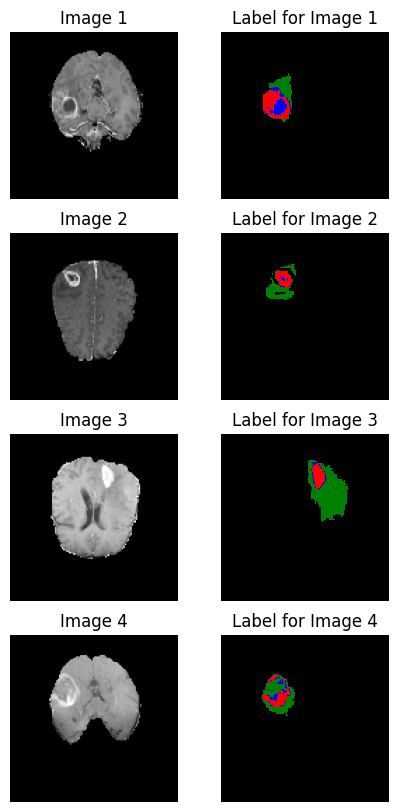

In [40]:
### Insert your code ###
image_path = 'Task01_BrainTumour_2D/training_images'
label_path = 'Task01_BrainTumour_2D/training_labels'

# get list of image names
image_names = os.listdir(image_path)

# create initial plot
plt.figure(figsize=(5, 10))

for i in range(1, 9, 2):
  # get random image
  random_image_name = np.random.choice(image_names)

  # retrieve and plot image
  image = imageio.imread(os.path.join(image_path, random_image_name))
  plt.subplot(4, 2, i)
  plt.imshow(image, cmap='gray')
  plt.title(f'Image {i//2 + 1}')
  plt.axis('off')

  # retrieve and plot label
  label = imageio.imread(os.path.join(label_path, random_image_name))
  plt.subplot(4, 2, i + 1)
  plt.imshow(label, cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
  plt.title(f'Label for Image {i//2 + 1}')
  plt.axis('off')

plt.show()

### End of your code ###

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [3]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        # get random indices of batch_size length
        indices = np.random.choice(len(self.images), batch_size, replace=False)
        # use indices to retrieve images and labels
        for i in indices:
            #add a channel dimmension (assume single channel)
            image = self.images[i][np.newaxis, :, :]
            images.append(image)
            labels.append(self.labels[i])

        images, labels = np.array(images), np.array(labels)

        ### End of your code ###
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [6]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        ### Insert your code ###
        n //= 2  # 64
        self.upconv3 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        self.conv3d = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2  # 32
        self.upconv2 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        self.conv2d = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n //= 2  # 16
        self.upconv1 = nn.ConvTranspose2d(n * 2, n, kernel_size=2, stride=2)
        self.conv1d = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        self.conv_out = nn.Conv2d(n, output_channel, kernel_size=1)

        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder

        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.upconv3(x)
        x = torch.cat([x, conv3_skip], dim=1)
        x = self.conv3d(x)

        x = self.upconv2(x)
        x = torch.cat([x, conv2_skip], dim=1)
        x = self.conv2d(x)

        x = self.upconv1(x)
        x = torch.cat([x, conv1_skip], dim=1)
        x = self.conv1d(x)

        x = self.conv_out(x)

        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [36]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            test_loss = 0
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)

            test_logits = model(test_images)
            test_loss = criterion(test_logits, test_labels).item()
            print(f'training loss: {loss:.8f}, test loss: {test_loss:.8f}')

            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda


<ipython-input-19-cdfd04bd864f>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
<ipython-input-19-cdfd04bd864f>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


training loss: 0.82993251, test loss: 0.97845834
training loss: 0.36124426, test loss: 0.41559553
training loss: 0.18752362, test loss: 0.21997993
training loss: 0.14703369, test loss: 0.14611827
training loss: 0.11072025, test loss: 0.09581836
training loss: 0.07491714, test loss: 0.11590803
training loss: 0.05439563, test loss: 0.09641907
training loss: 0.05976178, test loss: 0.09342597
training loss: 0.06408072, test loss: 0.07403240
training loss: 0.05906833, test loss: 0.10212070
training loss: 0.05791873, test loss: 0.04869401
training loss: 0.04925189, test loss: 0.07983788
training loss: 0.05584105, test loss: 0.06226223
training loss: 0.05129018, test loss: 0.04953412
training loss: 0.03870087, test loss: 0.06098583
training loss: 0.03060731, test loss: 0.06057370
training loss: 0.03530673, test loss: 0.04520177
training loss: 0.04571793, test loss: 0.03567378
training loss: 0.02991998, test loss: 0.05903164
training loss: 0.03295095, test loss: 0.03692973
training loss: 0.037

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

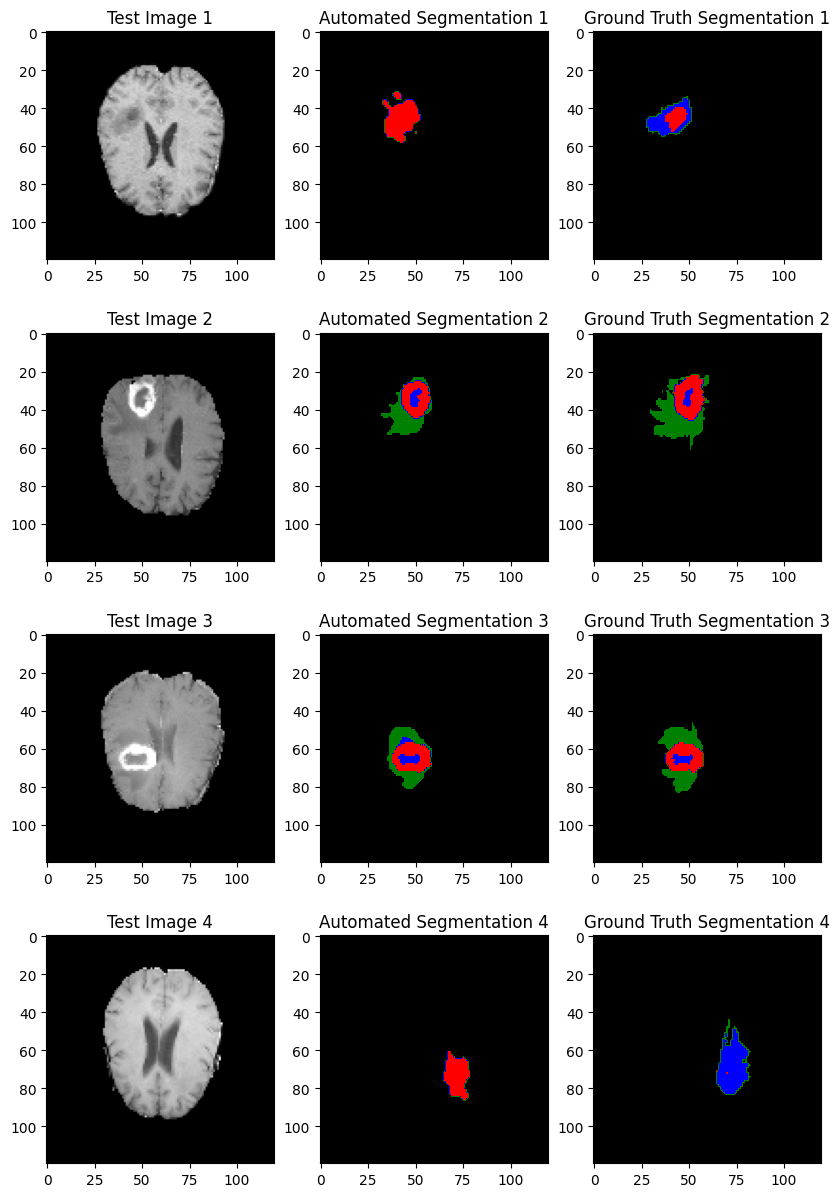

In [46]:
### Insert your code ###
test_set_size = 4

# get sorted list of models created
models_path = 'saved_models'
models = os.listdir(models_path)
models.sort(key=lambda x: int(x.split('_')[1].split('.')[0]), reverse=True)

# load model
model = UNet(output_channel=num_class)
model.load_state_dict(torch.load(os.path.join(models_path, models[0])))
model.to(device)
model.eval()

# retrieve test image and labels
images, labels = test_set.get_random_batch(test_set_size)
images = torch.from_numpy(images)
images = images.to(device, dtype=torch.float32)

# pass images through model for automated segmentation
with torch.no_grad():
  logits = model(images)
  p = torch.softmax(logits, dim=1)
  masks = torch.argmax(p, dim=1)

images_np = images.cpu().numpy()
masks_np = masks.cpu().numpy()

# create plot
plt.figure(figsize=(10, 15))
for i in range(test_set_size):
    # plot input image
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(images_np[i].squeeze(), cmap='gray')
    plt.title(f'Test Image {i + 1}')

    # plot automated segmentation
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(masks_np[i].squeeze(), cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    plt.title(f'Automated Segmentation {i + 1}')

    # plot ground truth
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(labels[i].squeeze(), cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    plt.title(f'Ground Truth Segmentation {i + 1}')

### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

The trained model performs well with a loss of 0.01087. For the most part, the model is able to take an input image and identify regions of interest that resemble the ground truth segmentation. However, for some test data, the model may misclassify or not completely capture regions.

Further improvements for the model include:


* **Adjusting model architecture:** adding more layers or increasing the number of neurons per layer allows the model to capture more complex underlying patterns in the data
* **Hyperparameter tuning:** optimising the learning rate or convolutional kernel size or stride by testing a range of values and picking the model with the lowest loss can help improve the model
* **Data augmentation:** transforming the training dataset with random rotations, flips, scaling and cropping can increase variability in data and help the model make better generalisations
* **Regularisation:** Introducing techniques such as L1 or L2 regularisation or dropout can prevent the model from relying on any one neuron and help with generalisation





In [47]:
!apt-get update
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [713 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,502 kB]
Get:13 http://archive.ubuntu.com/ubuntu

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
!jupyter nbconvert --output-dir='/content' --to latex '/content/drive/My Drive/Colab Notebooks/Computer_Vision_coursework_02.ipynb'

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/Computer_Vision_coursework_02.ipynb to latex
[NbConvertApp] Support files will be in Computer_Vision_coursework_02_files/
[NbConvertApp] Making directory /content/Computer_Vision_coursework_02_files
[NbConvertApp] Making directory /content/Computer_Vision_coursework_02_files
[NbConvertApp] Writing 100506 bytes to /content/Computer_Vision_coursework_02.tex


In [52]:
!buf_size=1000000 xelatex --interaction=nonstopmode 'Computer_Vision_coursework_02.tex'

This is XeTeX, Version 3.141592653-2.6-0.999993 (TeX Live 2022/dev/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./Computer_Vision_coursework_02.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))
(/usr/share/texlive/texmf-dist/tex/latex/tcolorbox/tcolorbox.sty
(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgf.sty
(/usr/share/texlive/texmf-dist/tex/latex/pgf/utilities/pgfrcs.sty
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-common.tex
(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-common-lists.t
ex)) (/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-latex.def
) (/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfrcs.code.tex
(/usr/share/texlive/texmf-dist/tex/generic/pg